In [51]:
import pandas as pd
import yfinance as yf 
import numpy as np
import matplotlib.pyplot as plt 
import re 
from sklearn.cluster import KMeans

In [52]:
# Manual inputs
TIMEFRAME = "1d"
LOOKBACK_PERIOD = "5y"

In [53]:
def get_list(path):
    tickers_txt = open(path, "r")
    tickers = tickers_txt.read().splitlines()
    tickers_txt.close()
    UNIVERSE = re.findall(":[A-Z]{1,5}", str(tickers)) # A ticker has 1-5 capital letters (Max: 5 chars for NYSE, 4 chars for NASDAQ)
    UNIVERSE = [ticker[1:] for ticker in UNIVERSE] # Remove the colon from the ticker
    return UNIVERSE

UNIVERSE = get_list("TradingView Watchlists/1. US Equity by Sectors.txt")
print(UNIVERSE)


['SPY', 'QQQ', 'META', 'GOOG', 'MSFT', 'AAPL', 'NTES', 'SAP', 'TSLA', 'STLA', 'TXN', 'TSM', 'QCOM', 'NVDA', 'VZ', 'T', 'NFLX', 'AXP', 'V', 'GS', 'IBKR', 'MRNA', 'ABT', 'MDT', 'LLY', 'PFE', 'UNH', 'ABBV', 'MRK', 'JNJ', 'BA', 'GD', 'RTX', 'LDOS', 'LMT', 'NOC', 'KO', 'MO', 'MCD', 'PM', 'SBUX', 'BABA', 'HD', 'CVX', 'XOM', 'SHEL', 'EQNR', 'COP']


In [54]:
stock_returns = []
for stock in UNIVERSE:
  returns = yf.Ticker(stock).history(period=LOOKBACK_PERIOD, interval=TIMEFRAME)
  returns["returns"] =  np.log(1+returns["Close"].pct_change()) # returns["Close"].pct_change()
  returns.rename(columns={"returns": stock}, inplace=True)
  stock_returns.append(returns[stock])

In [55]:
correl_matrix = pd.DataFrame(stock_returns).T.corr().round(4)

# Correlation matrix

In [56]:
SHOW_MATRIX = False 
_matrix = correl_matrix.style.background_gradient(cmap ='coolwarm')
if not SHOW_MATRIX:
  _matrix = None
_matrix

## Analysis: Market beta vs Market correlation

In [57]:
# Get data for the stock and SPY
stock = yf.Ticker("AAPL")
SPY = yf.Ticker("SPY")

def calc_beta(stock, benchmark="SPY"): 

    # Get the historical closes
    stock_hc = yf.Ticker(stock).history(period=LOOKBACK_PERIOD)
    benchmark_hc = yf.Ticker(benchmark).history(period=LOOKBACK_PERIOD)

    # Calculate the daily returns for the stock and SPY
    stock_returns = stock_hc['Close'].pct_change()
    SPY_returns = benchmark_hc['Close'].pct_change()

    # Calculate the beta of the stock against SPY
    covar = stock_returns.cov(SPY_returns)
    var = SPY_returns.var()

    return covar / var # beta

In [58]:
# Calc the beta in each of the stock in our UNIVESRE
beta_map = {}
for stock in UNIVERSE:
    beta_map[stock] = calc_beta(stock)


In [59]:
# Correl with SPY Map
correl_with_SPY_map = {}
for stock in UNIVERSE:
    correl_with_SPY_map[stock] = correl_matrix[stock]["SPY"]


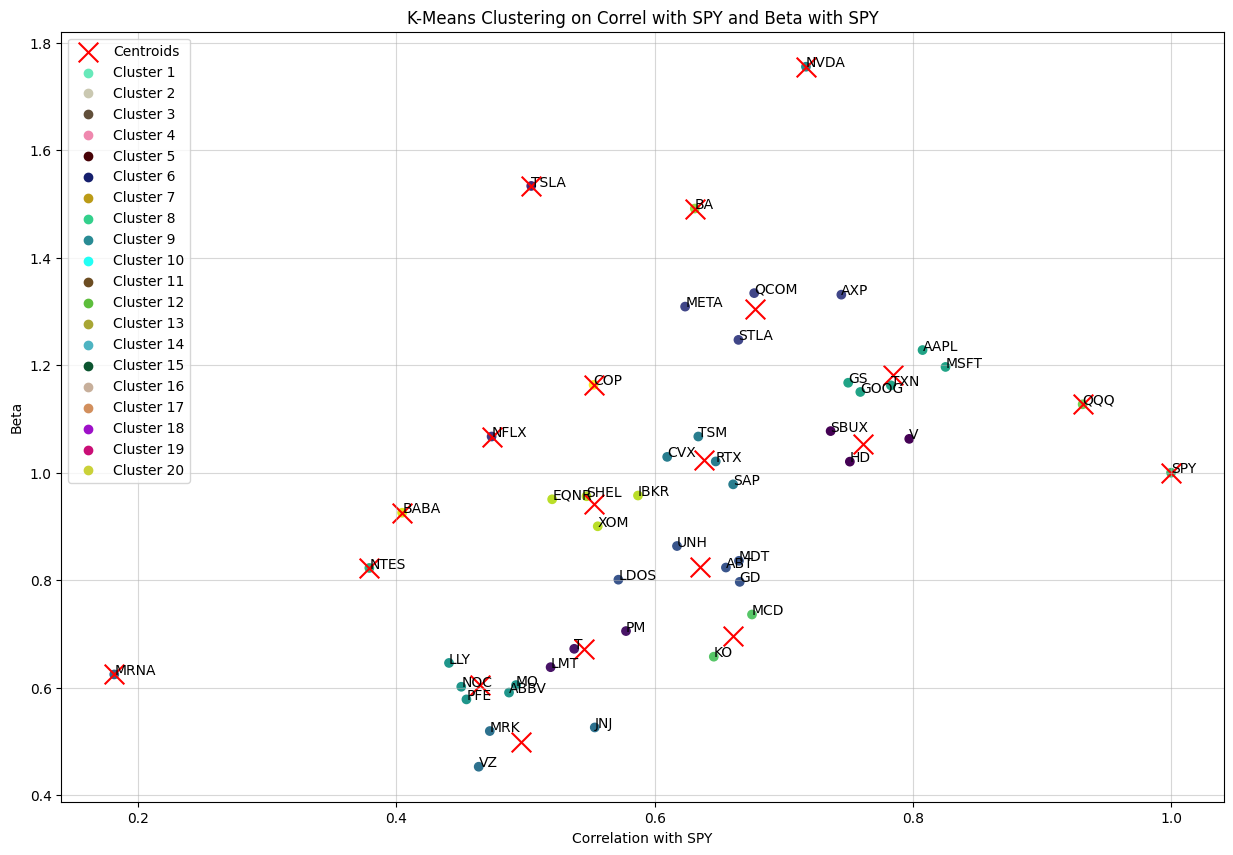

In [63]:
N_CLUSTERS = 20

# Features
X = pd.DataFrame(list(zip(correl_with_SPY_map.values(), beta_map.values())), columns=["Correl", "Beta"])

# Create a K-Means model with N_CLUSTERS clusters
kmeans = KMeans(n_clusters=N_CLUSTERS)

# Fit the model to the data
kmeans.fit(X)

# Predict the clusters
clusters = kmeans.predict(X)

# Add the clusters to the dataframe
X["Cluster"] = clusters

# Plot the clusters
plt.figure(figsize=(15, 10))
plt.scatter(X["Correl"], X["Beta"], c=X["Cluster"], cmap="viridis")
plt.xlabel("Correlation with SPY"), plt.ylabel("Beta")
plt.title("K-Means Clustering on Correl with SPY and Beta with SPY")
plt.grid(alpha=0.5)

# Add labels to each point
for label, correl in correl_with_SPY_map.items():
    beta = beta_map[label]
    plt.annotate(label, (correl, beta))

# Add the centroids to the plot
centroids = kmeans.cluster_centers_ 
plt.scatter(centroids[:, 0], centroids[:, 1], marker="x", s=200, c="red")

# Legend
plt.scatter([], [], marker="x", s=200, color="red", label="Centroids")
_colors = ["#"+''.join([np.random.choice(list('0123456789ABCDEF')) for j in range(6)]) for i in range(N_CLUSTERS)]
for i in range(N_CLUSTERS):
    plt.scatter([], [], color=_colors[i], label="Cluster "+str(i+1))
plt.legend();

plt.show()